In [24]:
pip install dtaidistance

In [25]:
import math, time, re
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
import matplotlib.pyplot as plt


In [26]:
BASE_DIR=Path("/content/drive/MyDrive/Dance_clean_data")

In [27]:
SEQ_IN,SEQ_OUT=30,30
BATCH_TRAIN=128
BATCH_EVAL=64
EPOCHS=10
LR=2e-4
WDECAY=0.0
GRAD_CLIP=1.0
DIFF_STEPS_TRAIN=400
SAMPLE_STEPS=100
GUIDE_W=2.0
DROP_P_CTX=0.10
WINDOW_STRIDE_EVAL=10
MAX_EVAL_WINDOWS=20000
MAX_DTW_SAMPLES=64
N_SAMPLES_PER_WIN=1
VEL_W=0.10


In [28]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP=torch.cuda.is_available()
torch.backends.cudnn.benchmark=True
try: torch.set_float32_matmul_precision('high')
except: pass

In [29]:
def dancer_from_path(p: Path):
    m=re.match(r"^(D\d+)",p.parent.name)
    return m.group(1) if m else p.parent.name

def load_npy_by_pattern(base_dir: Path,ps: str,edim=None):
    b={}
    for f in base_dir.rglob("*.npy"):
        if ps.lower() not in f.name.lower():
            continue
        arr=np.load(f)
        if arr.ndim!=2:
            continue
        if edim is not None and arr.shape[1]!=edim:
            continue
        d=dancer_from_path(f)
        b.setdefault(d, []).append(arr.astype(np.float32))
    return b

def vstack_or_empty(la,D=None):
    if not la:
        return np.empty((0, D if D is not None else 0),np.float32)
    return np.vstack(la).astype(np.float32)

In [30]:
def load_npy_by_pattern(base_dir: Path,ps: str,edim=None):
    b={}
    for f in base_dir.rglob("*.npy"):
        if ps.lower() not in f.name.lower():
            continue
        arr=np.load(f)
        if arr.ndim!=2:
            continue
        if edim is not None and arr.shape[1]!=edim:
            continue
        d=dancer_from_path(f)
        b.setdefault(d, []).append(arr.astype(np.float32))
    return b

def vstack_or_empty(la,D=None):
    if not la:
        return np.empty((0, D if D is not None else 0),np.float32)
    return np.vstack(la).astype(np.float32)

In [31]:
def build_io(data_2d,in_len=30,out_len=30,feat_dim=None,stride=1):
    T=len(data_2d)
    if feat_dim is None: feat_dim=data_2d.shape[1] if data_2d.ndim==2 else 0
    if T<in_len+out_len:
        return (np.empty((0,in_len,feat_dim),np.float32),
                np.empty((0,out_len,feat_dim),np.float32))
    X,Y=[],[]
    for i in range(0,T-in_len-out_len+1,stride):
        X.append(data_2d[i:i+in_len])
        Y.append(data_2d[i+in_len:i+in_len+out_len])
    return np.stack(X).astype(np.float32),np.stack(Y).astype(np.float32)

In [32]:
def fit_scaler(X_windows):
    sc=StandardScaler().fit(X_windows.reshape(-1, X_windows.shape[-1]))
    mu,sig=sc.mean_.astype(np.float32),sc.scale_.astype(np.float32)
    sig[sig==0]=1.0
    return mu, sig

def transform_safe(x,mu,sig): return (x - mu)/sig
def inv_transform_safe(x, mu, sig): return x*sig+mu

def vel(x):
    return x[:,1:,:]-x[:,:-1,:]

In [33]:
train_by_d=load_npy_by_pattern(BASE_DIR,"train")
zig_by_d=load_npy_by_pattern(BASE_DIR,"zigzag")
circ_by_d=load_npy_by_pattern(BASE_DIR,"circle")

all_ds=sorted(set(train_by_d)|set(zig_by_d)|set(circ_by_d))
def concat_all(b):
    if not b: return np.empty((0,0),np.float32)
    any_d=next(iter(b))
    Ddim=b[any_d][0].shape[1]
    return vstack_or_empty([arr for d in b for arr in b.get(d, [])], D=Ddim)

train_all=concat_all(train_by_d)
zig_all=concat_all(zig_by_d)
circ_all=concat_all(circ_by_d)
print("Shapes–train:", train_all.shape, " zig:", zig_all.shape, " circle:", circ_all.shape)
if train_all.size > 0: D = train_all.shape[1]
else: raise RuntimeError("No 'train' .npy found.")


Shapes–train: (331508, 112)  zig: (132034, 112)  circle: (138524, 112)


In [34]:
Xtr_raw,Ytr_raw=build_io(train_all,SEQ_IN,SEQ_OUT,feat_dim=D,stride=1)
print(f"Train windows:", Xtr_raw.shape,Ytr_raw.shape)
n=len(Xtr_raw)
if n==0: raise RuntimeError("No windows constructed from train data.")
n_val=max(int(0.1*n),1)
Xtr_raw,Ytr_raw,Xval_raw,Yval_raw=Xtr_raw[:-n_val],Ytr_raw[:-n_val],Xtr_raw[-n_val:],Ytr_raw[-n_val:]
print(f"Split- Train: {len(Xtr_raw)}  Val: {len(Xval_raw)}")


Train windows: (331449, 30, 112) (331449, 30, 112)
Split- Train: 298305  Val: 33144


In [35]:
mu,sig=fit_scaler(Xtr_raw)
Xtr=transform_safe(Xtr_raw,mu,sig)
Ytr=transform_safe(Ytr_raw,mu,sig)
Xval=transform_safe(Xval_raw,mu,sig)
Yval=transform_safe(Yval_raw,mu,sig)

ctx_last_tr=Xtr[:, -1, :]
ctx_last_val=Xval[:, -1, :]
Ytr_resid=Ytr-ctx_last_tr[:, None, :]
Yval_resid=Yval-ctx_last_val[:, None, :]

In [36]:
def cosine_beta_schedule(T,s=0.008):
    steps=T+1
    x=torch.linspace(0,T,steps,dtype=torch.float32)
    alphas_cumprod=torch.cos(((x/T)+s)/(1+s)*math.pi/2)**2
    alphas_cumprod=alphas_cumprod/alphas_cumprod[0]
    betas=1-(alphas_cumprod[1:]/alphas_cumprod[:-1])
    return torch.clip(betas,1e-6,0.999)

class DiffusionSchedule:
    def __init__(self, T, device):
        self.T=T
        self.device=device
        self.betas=cosine_beta_schedule(T).to(device)
        self.alphas=1.0-self.betas
        self.alphas_bar=torch.cumprod(self.alphas,dim=0)

    def q_sample(self,x0,t,noise):
        a_bar=self.alphas_bar[t].view(-1,1,1)
        return torch.sqrt(a_bar)*x0+torch.sqrt(1.0-a_bar)*noise

In [37]:
def sinusoidal_embedding(timesteps,dim):
    device=timesteps.device
    half=dim//2
    freqs=torch.exp(torch.linspace(0,1,half,device=device)*(-math.log(10000.0)))
    args=timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb=torch.cat([torch.sin(args),torch.cos(args)],dim=1)
    if dim%2==1: emb=torch.nn.functional.pad(emb,(0,1))
    return emb

In [38]:
class FiLMedResBlock(nn.Module):
    def __init__(self,C):
        super().__init__()
        self.n1=nn.GroupNorm(8,C)
        self.n2=nn.GroupNorm(8,C)
        self.act=nn.SiLU()
        self.c1=nn.Conv1d(C,C,3,padding=1)
        self.c2=nn.Conv1d(C,C,3,padding=1)
        self.to_gamma_beta=nn.Linear(C,2*C)

    def forward(self,x,cond_vec):
        gb=self.to_gamma_beta(cond_vec)
        gamma,beta=gb.chunk(2,dim=1)
        gamma=gamma.unsqueeze(-1); beta=beta.unsqueeze(-1)
        h=self.c1(self.act(self.n1(x)))
        h=(1+gamma)*h+beta
        h=self.c2(self.act(self.n2(h)))
        return x+h


In [39]:
class ContextEncoder(nn.Module):
    def __init__(self,in_dim,base=128):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv1d(in_dim,base,3,padding=1),
            nn.GroupNorm(8,base),
            nn.SiLU(),
            nn.Conv1d(base,base,3,padding=1),
            nn.GroupNorm(8,base),
            nn.SiLU(),
        )
    def forward(self,ctx_seq):
        x=ctx_seq.permute(0,2,1)
        h=self.net(x)
        g=h.mean(dim=-1)
        return g

In [40]:
class Diffusion(nn.Module):
    def __init__(self,in_dim,base=128,nblocks=6,t_dim=128,ctx_dim=128):
        super().__init__()
        self.proj_in=nn.Conv1d(in_dim,base, 1)
        self.blocks=nn.ModuleList([FiLMedResBlock(base) for _ in range(nblocks)])
        self.proj_out=nn.Conv1d(base,in_dim,1)

        self.t_mlp=nn.Sequential(nn.Linear(t_dim, base),nn.SiLU(),nn.Linear(base, base))
        self.ctx_enc=ContextEncoder(in_dim,base=ctx_dim)
        self.ctx_mlp=nn.Sequential(nn.Linear(ctx_dim, base),nn.SiLU(),nn.Linear(base, base))
        self.t_dim=t_dim

    def forward(self,x_t,ctx_seq,t):
        x=x_t.permute(0,2,1)
        h=self.proj_in(x)
        te=sinusoidal_embedding(t,self.t_dim).to(x_t.dtype)
        te=self.t_mlp(te)
        ce=self.ctx_mlp(self.ctx_enc(ctx_seq))
        cond=te+ce
        for blk in self.blocks:
            h=blk(h,cond)
        out=self.proj_out(h)
        return out.permute(0,2,1)

In [41]:
class DiffusionDataset(torch.utils.data.Dataset):
    def __init__(self,X_ctx,Y_resid):
        self.X=X_ctx; self.Y=Y_resid
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i]

In [42]:
def train_diffusion(Xtr,Ytr_resid,Xval,Yval_resid,d_feat,tag="All"):
    sched=DiffusionSchedule(DIFF_STEPS_TRAIN, device=DEVICE)
    model=Diffusion(in_dim=d_feat,base=128,nblocks=6,t_dim=128,ctx_dim=128).to(DEVICE)
    opt=torch.optim.AdamW(model.parameters(),lr=LR,weight_decay=WDECAY)
    loss_pos=nn.SmoothL1Loss()
    scaler=torch.amp.GradScaler("cuda", enabled=AMP)

    train_ds=DiffusionDataset(Xtr,Ytr_resid)
    val_ds=DiffusionDataset(Xval,Yval_resid)
    train_loader=DataLoader(train_ds,batch_size=BATCH_TRAIN,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_ds,batch_size=BATCH_TRAIN,shuffle=False,drop_last=False)

    print(f"\nTraining:")
    for ep in range(1, EPOCHS+1):
        model.train(); t0=time.time(); tot=0.0
        for xb,y0 in train_loader:
            xb=xb.to(DEVICE); y0=y0.to(DEVICE)
            Bn=xb.size(0)
            t=torch.randint(0,sched.T,(Bn,),device=DEVICE)
            xb_ctx=xb.clone()
            drop_ctx=(torch.rand(Bn,device=DEVICE)<DROP_P_CTX).float().view(Bn,1,1)
            xb_ctx=xb_ctx*(1.0-drop_ctx)

            noise=torch.randn_like(y0)
            with torch.amp.autocast("cuda", enabled=AMP):
                x_t=sched.q_sample(y0,t,noise)
                x0_pred=model(x_t,xb_ctx,t)
                loss=loss_pos(x0_pred, y0)+VEL_W*loss_pos(vel(x0_pred),vel(y0))

            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(),GRAD_CLIP)
            scaler.step(opt); scaler.update()
            tot+=loss.item()

        model.eval(); vtot=0.0; n_eval=0
        with torch.no_grad(), torch.amp.autocast("cuda", enabled=AMP):
            for xb,y0 in val_loader:
                xb=xb.to(DEVICE); y0=y0.to(DEVICE)
                Bn=xb.size(0)
                t=torch.randint(0,sched.T,(Bn,),device=DEVICE)
                noise=torch.randn_like(y0)
                x_t=sched.q_sample(y0,t,noise)
                x0_pred=model(x_t,xb,t)
                vloss=loss_pos(x0_pred,y0)+VEL_W*loss_pos(vel(x0_pred),vel(y0))
                vtot+=vloss.item(); n_eval+=1
                if n_eval>=10: break

        print(f"[{tag}] Epoch {ep:02d} | Train: {tot/len(train_loader):.5f}  Val: {vtot/max(n_eval,1):.5f}")
    return model,sched

In [43]:
@torch.no_grad()
def sample_windows(model,sched,X_pool,sample_steps=SAMPLE_STEPS,n_samples_per=N_SAMPLES_PER_WIN,batch_size=BATCH_EVAL,guide_w=GUIDE_W,device=DEVICE):
    model.eval()
    N,Lin,D=X_pool.shape
    Lout=SEQ_OUT
    preds_std=np.zeros((N,Lout,D),dtype=np.float32)
    for s in range(0,N,batch_size):
        e=min(N,s+batch_size); B=e-s
        ctx_seq=torch.tensor(X_pool[s:e],device=device,dtype=torch.float32)
        ctx_last=ctx_seq[:, -1, :]

        K=n_samples_per
        ctxK=ctx_seq.repeat_interleave(K,dim=0)
        x_t=torch.randn((B*K,Lout,D),device=device,dtype=torch.float32)
        null_ctx=torch.zeros_like(ctxK)
        t_seq=torch.linspace(sched.T-1,1,steps=sample_steps,device=device).long().view(1,-1).repeat(B*K, 1)
        t_prev=torch.cat([t_seq[:,1:],torch.zeros((B*K,1),device=device,dtype=torch.long)], dim=1)

        for k in range(sample_steps):
            tk =t_seq[:,k]
            tpk=t_prev[:,k]
            a_t=sched.alphas_bar[tk].view(-1,1,1)
            a_tp=sched.alphas_bar[tpk].view(-1,1,1)
            x0_c=model(x_t,ctxK,tk)
            x0_u=model(x_t,null_ctx,tk)
            eps_c=(x_t-torch.sqrt(a_t)*x0_c)/torch.sqrt(1.0-a_t+1e-12)
            eps_u=(x_t-torch.sqrt(a_t)*x0_u)/torch.sqrt(1.0-a_t+1e-12)
            eps=eps_u+guide_w*(eps_c-eps_u)
            x0=(x_t-torch.sqrt(1.0-a_t)*eps)/torch.sqrt(a_t+1e-12)
            x_t=torch.sqrt(a_tp)*x0+torch.sqrt(1.0-a_tp)*eps
            x_t=torch.nan_to_num(x_t,nan=0.0,posinf=10.0,neginf=-10.0).clamp_(-10.0, 10.0)

        x_np=x_t.detach().cpu().numpy()
        x_np=x_np.reshape(B,K,Lout,D)
        if K==1:
            preds_std[s:e]=x_np[:,0,:,:]+ctx_last.detach().cpu().numpy()[:, None, :]
        else:
            x_mean=x_np.mean(axis=1)+ctx_last.detach().cpu().numpy()[:, None, :]
            preds_std[s:e]=x_mean

    return preds_std

In [44]:
def evaluate_diffusion(model,sched,Xs,Ys,name="", dtw_n=MAX_DTW_SAMPLES,sample_steps=SAMPLE_STEPS,n_samples_per=N_SAMPLES_PER_WIN, guide_w=GUIDE_W):
    if len(Xs)==0:
        print(f"{name}: 0 windows."); return None
    preds_std=sample_windows(
        model,sched,X_pool=Xs,
        sample_steps=sample_steps,n_samples_per=n_samples_per,
        batch_size=BATCH_EVAL,guide_w=guide_w,device=DEVICE)
    gt=Ys
    l1=float(np.mean(np.abs(preds_std-gt)))
    l2=float(np.mean((preds_std-gt)**2))
    k=min(len(gt),dtw_n)
    dtws=[dtw.distance(preds_std[i].reshape(-1),gt[i].reshape(-1)) for i in range(k)]
    print(f"{name}: L1={l1:.4f}  L2={l2:.4f}  DTW(n={k})={np.mean(dtws):.4f}")
    return {"l1": l1, "l2": l2, "dtw": float(np.mean(dtws))}

In [45]:
def windows_eval(long_arr,mu,sig,d_feat,name,stride=WINDOW_STRIDE_EVAL,cap=MAX_EVAL_WINDOWS):
    Xr,Yr=build_io(long_arr,SEQ_IN,SEQ_OUT,feat_dim=d_feat,stride=stride)
    if Xr.size==0:
        #print(f"[eval-build] {name}: 0 windows")
        return (np.empty((0,SEQ_IN,d_feat), np.float32),np.empty((0,SEQ_OUT,d_feat), np.float32))
    if len(Xr) > cap:
        idx=np.linspace(0, len(Xr)-1, num=cap, dtype=int)
        Xr,Yr=Xr[idx],Yr[idx]
    Xs=transform_safe(Xr,mu,sig)
    Ys=transform_safe(Yr,mu,sig)
    #print(f"[eval-build] {name}: {Xs.shape} windows (cap={cap})")
    return Xs,Ys

In [46]:
model_all,sched_all=train_diffusion(Xtr=Xtr,Ytr_resid=Ytr_resid,Xval=Xval,Yval_resid=Yval_resid,d_feat=D,tag="ALL")


Training:
[ALL] Epoch 01 | Train: 0.00895  Val: 0.00393
[ALL] Epoch 02 | Train: 0.00367  Val: 0.00325
[ALL] Epoch 03 | Train: 0.00295  Val: 0.00336
[ALL] Epoch 04 | Train: 0.00256  Val: 0.00233
[ALL] Epoch 05 | Train: 0.00237  Val: 0.00287
[ALL] Epoch 06 | Train: 0.00216  Val: 0.00174
[ALL] Epoch 07 | Train: 0.00201  Val: 0.00185
[ALL] Epoch 08 | Train: 0.00195  Val: 0.00153
[ALL] Epoch 09 | Train: 0.00186  Val: 0.00226
[ALL] Epoch 10 | Train: 0.00179  Val: 0.00191


In [47]:
Xs_tr_eval,Ys_tr_eval=windows_eval(train_all,mu,sig,D,"Diff-Train")
evaluate_diffusion(model_all,sched_all,Xs_tr_eval,Ys_tr_eval,name="Diff – Train",dtw_n=MAX_DTW_SAMPLES,sample_steps=SAMPLE_STEPS,n_samples_per=N_SAMPLES_PER_WIN,guide_w=GUIDE_W)

Xs_zig,Ys_zig=windows_eval(zig_all,mu,sig,D,"Diff-Zigzag")
Xs_cir,Ys_cir=windows_eval(circ_all,mu,sig,D,"Diff-Circle")

Diff – Train: L1=0.0579  L2=0.0314  DTW(n=64)=3.2084


In [48]:
evaluate_diffusion(model_all,sched_all,Xs_zig,Ys_zig,name="Diff–Zigzag",dtw_n=MAX_DTW_SAMPLES,sample_steps=SAMPLE_STEPS,n_samples_per=N_SAMPLES_PER_WIN,guide_w=GUIDE_W)
evaluate_diffusion(model_all, sched_all, Xs_cir, Ys_cir, name="Diff–Circle",dtw_n=MAX_DTW_SAMPLES,sample_steps=SAMPLE_STEPS,n_samples_per=N_SAMPLES_PER_WIN,guide_w=GUIDE_W)

Diff–Zigzag: L1=0.1162  L2=0.0710  DTW(n=64)=5.1521
Diff–Circle: L1=0.1086  L2=0.0479  DTW(n=64)=7.1969


{'l1': 0.10856655985116959,
 'l2': 0.04792416840791702,
 'dtw': 7.196859816994458}

In [49]:
@torch.no_grad()
def _ddim_sample(model,sched,X_ctx_std,seq_out=SEQ_OUT,sample_steps=SAMPLE_STEPS,guide_w=GUIDE_W,device=DEVICE):
    B,Lin,D=X_ctx_std.shape
    assert B==1
    X_pool=X_ctx_std.detach().cpu().numpy()
    preds_std=sample_windows(
        model,sched,
        X_pool=X_pool,
        sample_steps=sample_steps, n_samples_per=1,
        batch_size=1, guide_w=guide_w, device=device)
    return torch.from_numpy(preds_std).to(device)

In [50]:
@torch.no_grad()
def predict_full_file_diffusion(arr,model,mu,sig,sched,
    seq_in=30, seq_out=30, step=1,
    sample_steps=60, guide_w=2.0,
    batch_windows=256,
    device=DEVICE
):

    model.eval()
    T,D=arr.shape
    if T<=seq_in:
        raise ValueError("File too short to predict: T=seq_in")
    Xs=(arr-mu)/sig
    starts=list(range(0,T-seq_in,step))
    N=len(starts)
    if N==0:
        return arr.copy(),np.zeros((T,),dtype=bool)

    pred_sum=np.zeros((T,D),dtype=np.float32)
    pred_count=np.zeros((T,),dtype=np.int32)

    for s0 in range(0,N,batch_windows):
        s1=min(N,s0+batch_windows)
        B=s1-s0
        ctx_batch=np.stack([Xs[i:i+seq_in] for i in starts[s0:s1]], axis=0).astype(np.float32)

        preds_std=sample_windows(
            model, sched, X_pool=ctx_batch,
            sample_steps=sample_steps, n_samples_per=1,
            batch_size=BATCH_EVAL, guide_w=guide_w, device=device)

        for j in range(B):
            s=starts[s0+j]
            L=min(seq_out,T-(s+seq_in))
            if L<=0: continue
            t_slice=slice(s+seq_in,s+seq_in+L)
            pred_sum[t_slice]+=preds_std[j,:L,:]
            pred_count[t_slice]+=1

    valid=pred_count>0
    pred_full_std =np.zeros_like(arr, dtype=np.float32)
    den=np.maximum(pred_count[valid].astype(np.float32)[:, None], 1.0)
    pred_full_std[valid]=pred_sum[valid]/den
    pred_full_std[:seq_in]=Xs[:seq_in]
    pred_full=pred_full_std*sig+mu
    return pred_full,valid



In [51]:
def _prep_xyz(gt,pred,xyz_idx=(0,1,2),normalize_to_last_context=True,ctx_len=30):
    xi,yi,zi=xyz_idx
    T=gt.shape[0]
    gt_xyz=gt[:, [xi, yi, zi]].astype(np.float32)
    pred_xyz=pred[:, [xi,yi, zi]].astype(np.float32)

    if normalize_to_last_context and T > ctx_len:
        origin=gt_xyz[ctx_len-1].copy()
        gt_xyz=gt_xyz-origin
        pred_xyz =pred_xyz-origin
        ctx_pt=np.zeros(3, np.float32)
        suffix=" (normalized to last context)"
    else:
        ctx_pt=gt_xyz[min(ctx_len-1, T-1)]
        suffix=""
    return gt_xyz,pred_xyz,ctx_pt,suffix

def plot_3d(gt,pred,title="file (X–Z view)", xyz_idx=(0,1,2), normalize_to_last_context=True, ctx_len=30,elev=15, azim=90, figsize=(12,9)):
    gt_xyz,pred_xyz,ctx_pt, suffix = _prep_xyz(
        gt, pred, xyz_idx, normalize_to_last_context, ctx_len
    )
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(gt_xyz[ctx_len:,0],   gt_xyz[ctx_len:,1],   gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,1], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax.scatter(ctx_pt[0], ctx_pt[1], ctx_pt[2], s=60, c='k', label='context end')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(title + suffix); ax.legend(); plt.tight_layout(); plt.show()


def plot_2d(gt,pred,title="file", xyz_idx=(0,1,2),normalize_to_last_context=True, ctx_len=30, figsize=(14,4.5)):
    gt_xyz, pred_xyz, ctx_pt, suffix = _prep_xyz(gt,pred,xyz_idx,normalize_to_last_context,ctx_len)
    fig,axes=plt.subplots(1,3,figsize=figsize)
    (ax_xy, ax_xz, ax_yz) = axes

    ax_xy.plot(gt_xyz[ctx_len:,0], gt_xyz[ctx_len:,1], '--', lw=2, label='GT')
    ax_xy.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,1], '-',  lw=2, label='Pred')
    ax_xy.scatter(ctx_pt[0], ctx_pt[1], c='k', marker='x', s=50); ax_xy.set_title(f"{title} – X–Y{suffix}")

    ax_xz.plot(gt_xyz[ctx_len:,0], gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax_xz.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax_xz.scatter(ctx_pt[0], ctx_pt[2], c='k', marker='x', s=50); ax_xz.set_title("X–Z")

    ax_yz.plot(gt_xyz[ctx_len:,1], gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax_yz.plot(pred_xyz[ctx_len:,1], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax_yz.scatter(ctx_pt[1], ctx_pt[2], c='k', marker='x', s=50); ax_yz.set_title("Y–Z")

    for ax in axes: ax.legend(); ax.grid(True, alpha=0.2)
    plt.tight_layout(); plt.show()


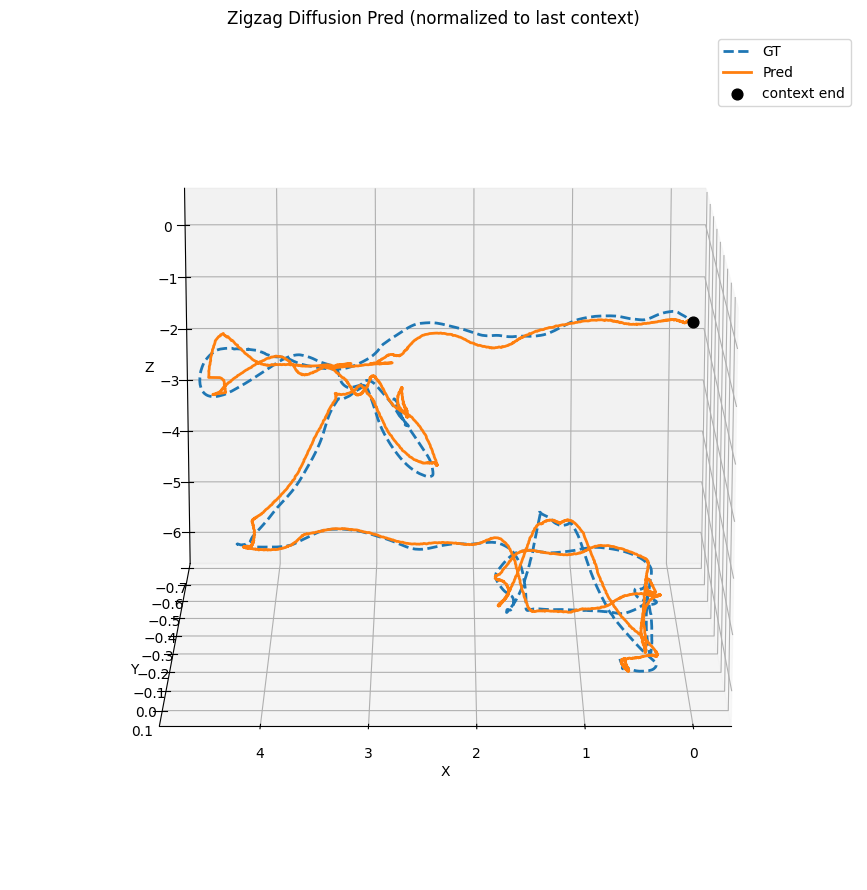

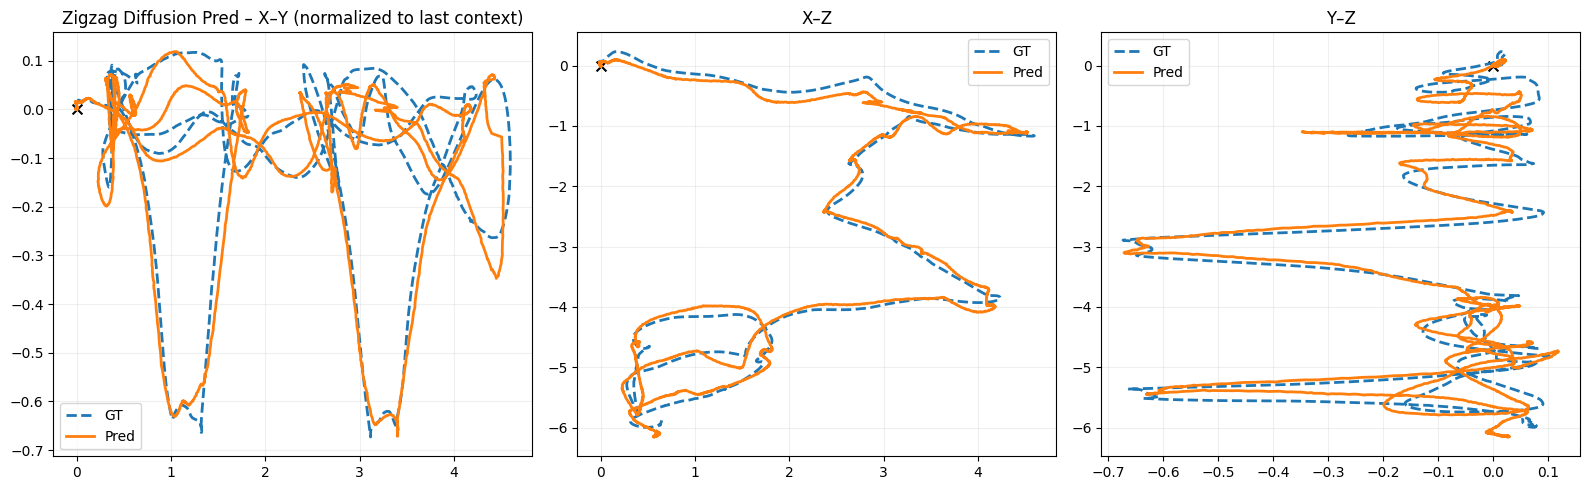

In [53]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D1_All_CSVs/cleaned_Take 072817_Sub1_NewZigZag1 12.26.30 PM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred, mask = predict_full_file_diffusion(
     arr=arr, model=model_all, mu=mu, sig=sig, sched=sched_all,
     seq_in=30, seq_out=30, step=1, sample_steps=100, guide_w=2.0, device=DEVICE)
plot_3d(gt=arr, pred=pred,
                  title="Zigzag Diffusion Pred", xyz_idx=(16,17,18),
                  normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred,
                  title="Zigzag Diffusion Pred", xyz_idx=(16,17,18),
                  normalize_to_last_context=True, ctx_len=30, figsize=(16,5))

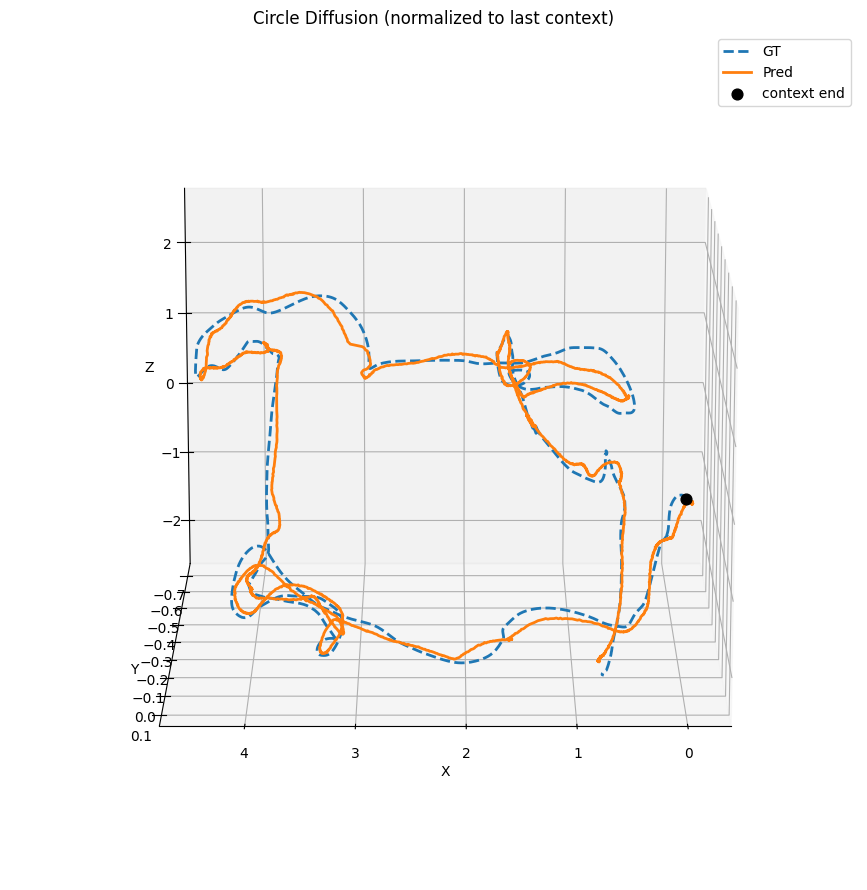

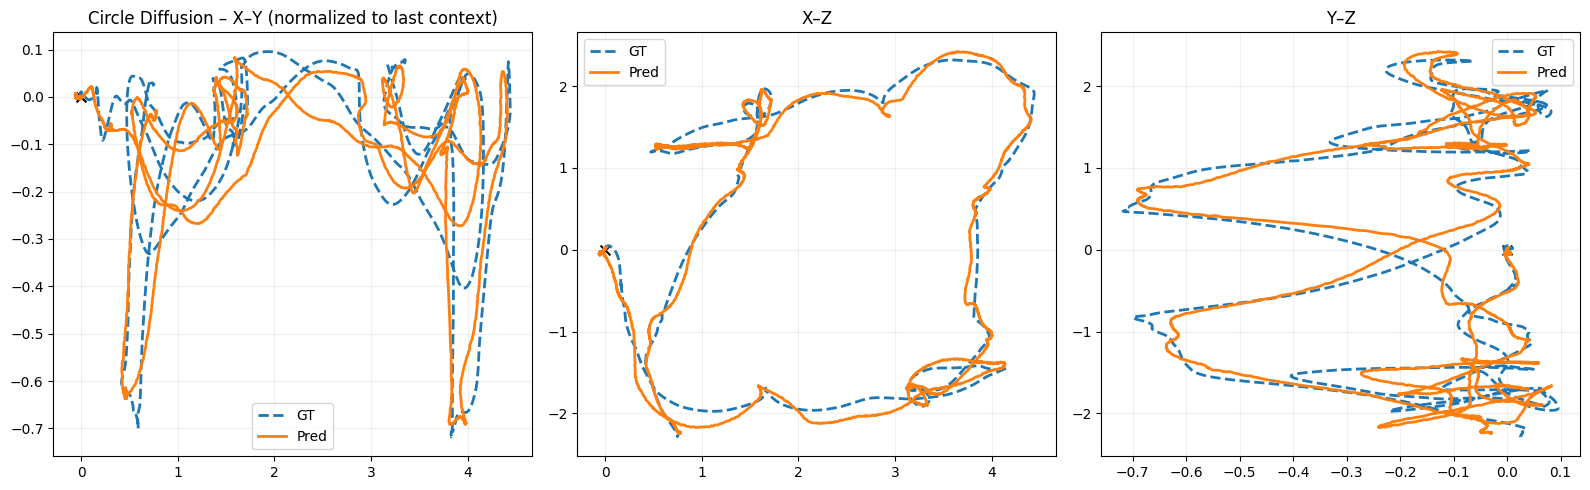

In [54]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_Circle3 01.12.49 PM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred, mask = predict_full_file_diffusion(
     arr=arr, model=model_all, mu=mu, sig=sig, sched=sched_all,
     seq_in=30, seq_out=30, step=1, sample_steps=100, guide_w=2.0, device=DEVICE)

plot_3d(gt=arr, pred=pred,
                  title="Circle Diffusion", xyz_idx=(16,17,18),
                  normalize_to_last_context=True, ctx_len=30, figsize=(12,9))

plot_2d(gt=arr, pred=pred,
                  title="Circle Diffusion", xyz_idx=(16,17,18),
                  normalize_to_last_context=True, ctx_len=30, figsize=(16,5))